# Builder Tutorial number 3

The builder tutorials demonstrate how to build an operational GSFLOW model using `pyGSFLOW` from shapefile, DEM, and other common data sources. These tutorials focus on the `gsflow.builder` classes.

## Calculating flow direction and flow accumulation arrays

In this tutorial, we demonstrate how to calculate flow direction and flow accumulation arrays for use in building new GSFLOW models. Generating these datasets is necessary for later defining model stream networks and cascades. 

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import flopy
from gsflow.builder import GenerateFishnet

### The `FlowAccumulation` class

The `FlowAccumulation` class performs many operations including generating flow direction arrays and flow accumulation arrays. This example notebook focuses is on the `flow_direction` and `flow_accumulation` methods of this class. Other methods are presented in following tutorials.

The `FlowAccumulation` class has 3 required parameters and 5 optional input parameters:  

**REQUIRED Parameters**
   - `data` : resampled dem data array of dimension nrow, ncol (matches modelgrid dimension)
   - `xcenters` : a two dimensional array of x coordinate cell centers (dimension nrow, ncol)
   - `ycenters` : a two dimensional array of y coordinate cell centers (dimension nrow, ncol)

**OPTIONAL Parameters**
   - `acc_type` : flow accumlation type, currently only "d8" is supported
   - `hru_type` : optional hru_type array where 0=inactive, 1=land, 2=lake, and 3=swale
   - `closed_basin` : If true hru_type 2 is used in the flow direction calculations. False ignores hru_type 2. Default is False.
   - `flow_dir_array` : previously calculated flow direction array. This parameter is used to restart the class without performing flow direction analysis
   - `verbose` : boolean flag to print verbose output
   
The resulting object contains a number of methods that will be covered over several notebooks.

Let's start with importing the class

In [2]:
from gsflow.builder import FlowAccumulation

## Applying the methods to the Sagehen 50m example problem

In this example the methods are applied directly to the Sagehen 50m model as they are presented.

In [3]:
# define the input and output data paths
input_ws = os.path.join("data", "sagehen", "50m_tutorials")
output_ws = os.path.join("data", "temp")

# define the modelgrid and resampled DEM data paths
mg_file = os.path.join(input_ws, "sagehen_50m_grid.bin")
dem_data = os.path.join(input_ws, "sagehen_50m_dem_median.txt")

### Instantiating the `FlowAccumulation` class for the first time

For the first time instantiating the class for the Sagehen 50m model, the modelgrid cell center coordinates, and dem data are supplied to the `FlowAccumulation` class. 

By only suppling these three required data sets, `FlowAccumulation` assumes that all cells are active land cells. The user can optionally supply a `hru_type` array if they would like to exclude certain areas from the flow direction and accumulation calculations. 

In [4]:
# load modelgrid
modelgrid = GenerateFishnet.load_from_file(mg_file)
dem_data = np.genfromtxt(dem_data)

# instatiate the FlowAccumulation object
fa = FlowAccumulation(
    dem_data,
    modelgrid.xcellcenters,
    modelgrid.ycellcenters,
    verbose=True
)

### Calculating the D8 flow direction array

The D8 flow direction calculation encodes a digital number based on maximum slope between a cell and it's nearest neighbors. The figure below shows the digital number that is encoded for each possible flow direction.

<img src = "./figures/8.5.1.png">

Because D8 flow directions only code a single outlet direction connectivity of the network can be described as many cells can flow to one cell, and one cell can only flow to a single downgradient neighbor. 

The `flow_directions()` method performs these calculations and has two optional parameters:
   - `dijkstra` : boolean flag to perform a modified version of dijkstra's algorithm to solve the maze problem in digitally flat areas. Default method is to use a topological method, which performs well in areas with adequate topography.
   - `breach` : optional parameter that is the absolute value of breaching tolerance for digital dams. This parameters allows the flow direction routine to ignore small artifacts. Use caution when applying breaching values; they should be small numbers.
   
In this example dijkstra's algorithm is used and a small breaching tolerance is applied to overcome a single digital dam in the dem data. 

In [5]:
# use a small breaching tolerance and dijkstra's algorithm in this example
flow_directions = fa.flow_directions(dijkstra=True, breach=0.001)

Applying Dijkstra solution to resolve flat area:
pass # 0
Applying Dijkstra solution to resolve flat area:
pass # 0
pass # 20
pass # 40
pass # 60
pass # 80
Applying Dijkstra solution to resolve flat area:
pass # 0
pass # 20
pass # 40
pass # 60
Applying Dijkstra solution to resolve flat area:
pass # 0


Now let's inspect the flow direction array that we've generated

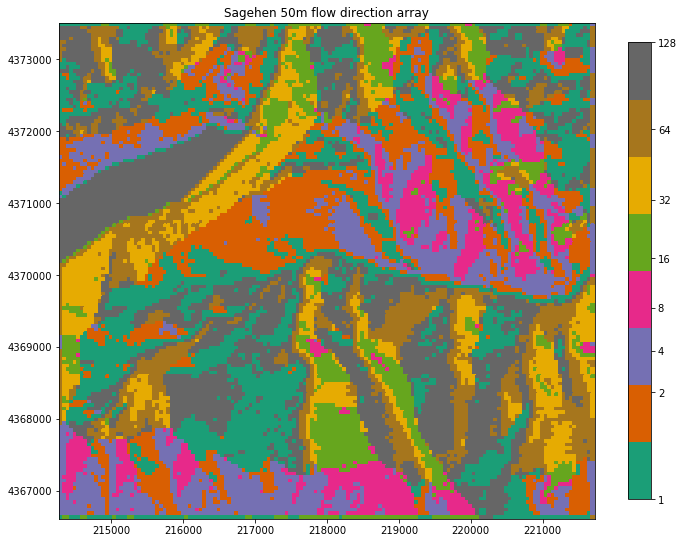

In [6]:
# plot the flow direction array
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pc = pmv.plot_array(
    flow_directions, vmin=1, vmax=128, cmap="Dark2", norm=mcolors.PowerNorm(0.3)
)
plt.title("Sagehen 50m flow direction array")
plt.colorbar(pc, shrink=0.7, ticks=[1, 2, 4, 8, 16, 32, 64, 128])
plt.show();

Alternatively we can plot this data as a flow vector (quiver) chart

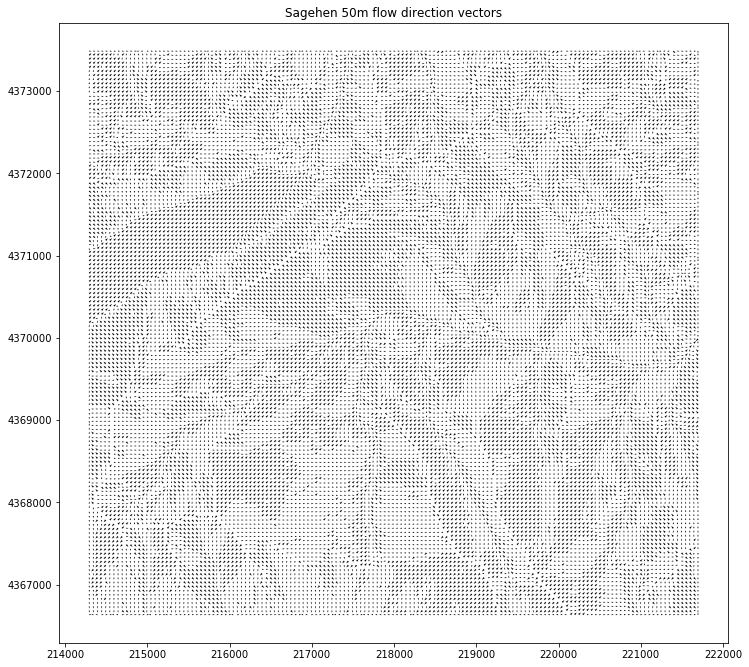

In [7]:
qx, qy = fa.get_vectors

# plot the flow directions as a quiver map
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
plt.quiver(modelgrid.xcellcenters, modelgrid.ycellcenters, qx, qy)
plt.title("Sagehen 50m flow direction vectors")
plt.show();

### Calculating the flow accumulation array

The flow accumulation array is calculated using Number of Input Drainage Paths (NIDP) methodology to deterine the contributing drainage area (number of cells) that drain to each model grid cell. 

Flow accumulation can be run after the flow direction array has been produced by calling the `flow_accumulation()` method.

In [8]:
# run flow accumulation
flow_accumulation = fa.flow_accumulation()

Now let's inspect the flow accumulation array by plotting it

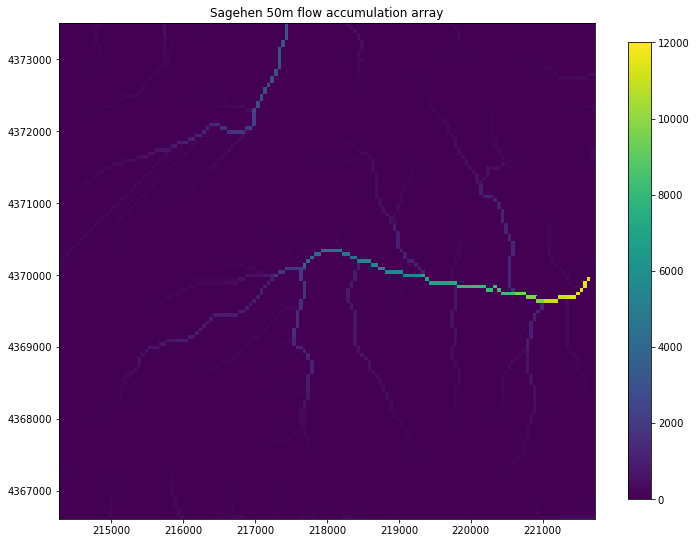

In [9]:
# plot the flow accumulation array
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pc = pmv.plot_array(
    flow_accumulation, vmin=0, vmax=12000
)
plt.title("Sagehen 50m flow accumulation array")
plt.colorbar(pc, shrink=0.7)
plt.show();

## Saving flow direction and flow accumulation arrays for later use

The builder methods allow the user to save the flow direction and flow accumulation arrays and pick up where they left off in another session or script. 

These arrays can be saved using numpy's `savetxt()` method. 

*In the next tutorial, we'll reload both of these arrays and pick up from where we left off.*

In [10]:
np.savetxt(
    os.path.join(output_ws, "sagehen_50m_flowdir.txt"), 
    flow_directions.astype(int), 
    delimiter="  ", 
    fmt="%d")

np.savetxt(
    os.path.join(output_ws, "sagehen_50m_flowacc.txt"),
    flow_accumulation,
    delimiter="  "
)

## Saving the depressionless DEM

The `FlowAccumulation` method automatically fills pits within the raster. Because of this, it is reccomended that the user save the depressionless DEM for later use after flow direction and flow accumulation have been performed. 

In [11]:
np.savetxt(
    os.path.join(output_ws, "sagehen_50m_dem.txt"),
    fa.get_dem_data(),
    delimiter="  "
)